In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import src.segnet_model as segnet_model
import src.segtools as segtools
from keras import optimizers
from glob import glob
import os
import json
from PIL import Image
%matplotlib inline


Using TensorFlow backend.


In [2]:
model_json = './fit_models/v5/seg_net.json' 
model_weight = './fit_models/v5/seg_net.h5' 
model = segnet_model.import_model(model_json, model_weight)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
print('Model compiled!')

Model compiled!


In [ ]:
with open('/contents/fit_models/v5/model_acc.json', 'r') as fout:
    model_out = json.load(fout)
'''
b = {'loss':[], 'categorical_accuracy':[]} #emtpy dict
for d in model_out:
    for k,v in d.items():
        #print(k,v)
        b[k].append(v[0])
'''
# the above as a one liner
b = {k:[d[k][0] for d in model_out] for d in model_out for k,v in d.items()} 

# plot for accuracy/epoch
f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(b['loss'])
ax[1].plot(b['categorical_accuracy'])
keys = list(b.keys())
for i in range(len(keys)):
    ax[i].plot(b[keys[i]])
    ax[i].set_xlabel('Epochs', fontsize=16)
    ax[i].set_ylabel(keys[i], fontsize=16)
    ax[i].set_xticklabels(ax[i].get_xticks(),fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(),fontsize=14)

In [3]:
# get validation data to check things out
val_batch = 200
val_generator = segtools.data_generator('/contents/images/val', batch_size=200)
x_val, y_val = next(val_generator)
n_classes = 2

In [4]:
pr = model.predict(x_val)
predictions = []
for i in range(len(pr)):
    predictions.append(pr[i].reshape((256,256,n_classes)))
predictions = np.array(predictions)
norm_pred = segtools.normalize_stack(predictions[:,:,:,0])

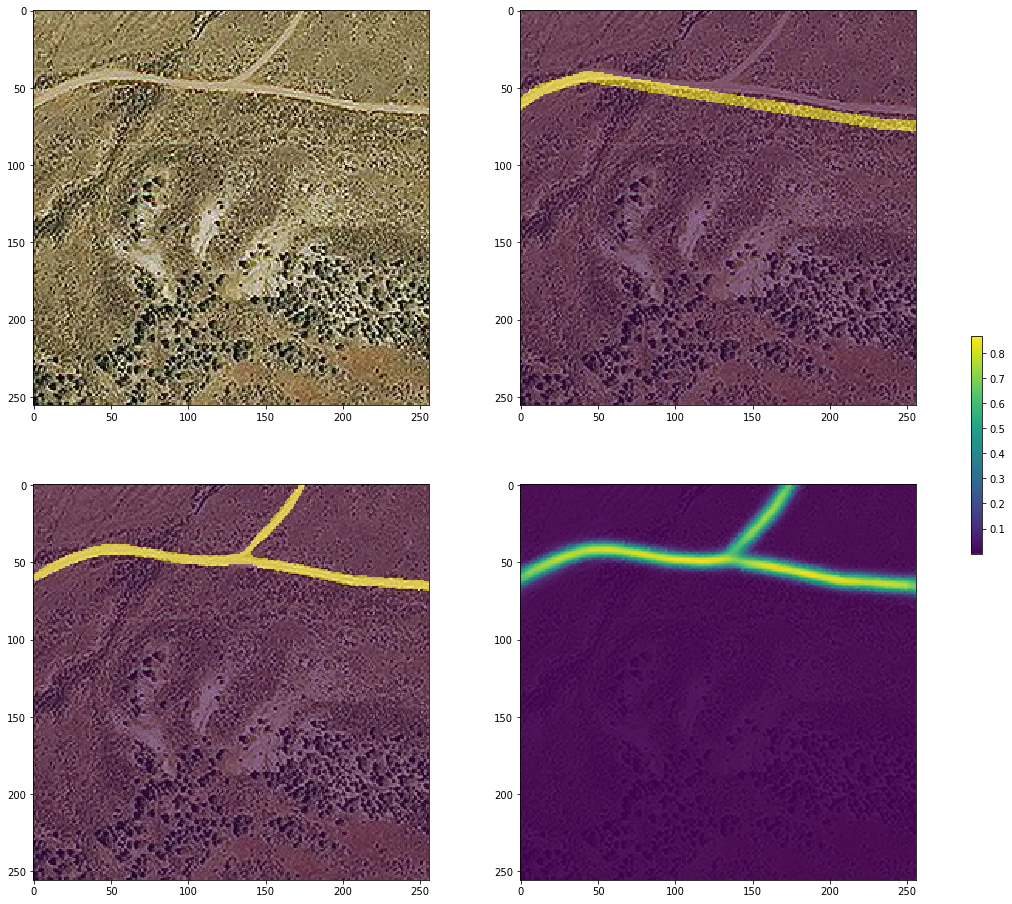

In [19]:
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample = np.random.randint(0, len(x_val))
sample = 96
x_ = x_val[sample].astype('float32')
y_ = y_val[sample].reshape(256,256,n_classes)[:,:,0]
ax[0,0].imshow(x_)
ax[0,1].imshow(x_)
ax[0,1].imshow(y_, alpha=0.5)
ax[1,0].imshow(x_)
#mask = np.zeros((256,256))
#mask[norm_pred[sample]>=thr] = 1
#ax[1,0].imshow(mask,alpha=0.5)
mask = np.argmax(pr[sample].reshape(256,256,n_classes), axis=2)
y_hat = ~mask
ax[1,0].imshow(x_)
ax[1,0].imshow(y_hat, alpha=0.5)

ax[1,1].imshow(x_)
im = ax[1,1].imshow(norm_pred[sample], alpha=0.9)
f.colorbar(im, ax=ax.ravel().tolist(), shrink=0.25)
f.savefig('')

In [9]:
sample

96

0.00840604214187 0.261408730159 0.0162883061089


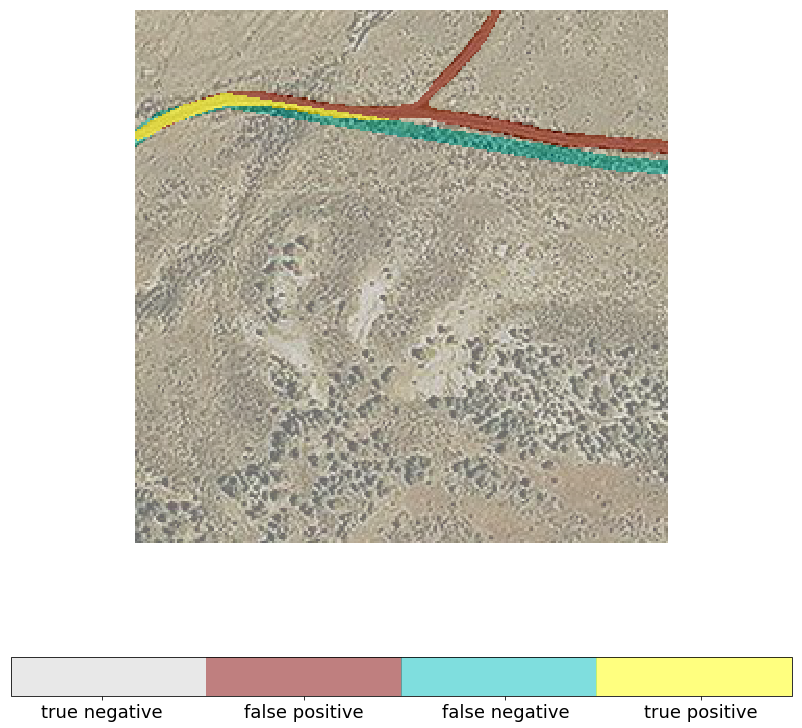

In [27]:
N = 4
model_acc_classes = 2*y_val[sample].reshape(256,256,n_classes)[:,:,0] - \
    np.argmax(pr[sample].reshape(256,256,n_classes), axis=2)
c, counts = np.unique(model_acc_classes, return_counts=True)
# {'TN': -1, 'FP': 0, 'FN' : 1, 'TP': 2}
precision = counts[3]/(counts[3]+counts[0])
recall = counts[3]/(counts[3]+counts[1])
f1 = 2*((precision*recall)/(precision+recall))
print(precision, recall, f1)
f, ax = plt.subplots(1,1,figsize=(14,14))
ax.set_axis_off()
cmap = mpl.colors.ListedColormap(['lightgrey','maroon','c', 'yellow'])
ax.imshow(x_)
im=ax.imshow(model_acc_classes, cmap=cmap, alpha=0.5)
bounds = [-0.65, 0.125, 0.9, 1.65]
labels = ['true negative', 'false positive', 'false negative', 'true positive']
cb = f.colorbar(im, orientation='horizontal')
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
f.savefig('/contents/outputs/example_acc_out.png', dpi=600, bbox_inches='tight')

In [ ]:
# construct a confusion matrix using various masks...
def generate_threshold_mask(pr, thr):
    c = pr[:,:,0].reshape((pr.shape[0]*pr.shape[1])).astype('float16')
    input_shape = c.shape
    mask = np.zeros((c.shape[0])).astype('bool')
    mask[c>=thr] = True 
    return(mask)

In [ ]:
t_min = 0
t_max = 1 
n_thr = 100 

target = y_val[:,:,0].reshape((y_val.shape[0]*y_val.shape[1])).astype('bool')
n_cells = target.shape[0]
n_c1 = np.sum(target)
n_c0 = n_cells - n_c1

#overall accuracy.
sensitivity = []
specificity = []
thresholds = np.linspace(t_min, t_max, n_thr)
for thr in thresholds:
    mask = generate_threshold_mask(pr, thr)
    sensitivity.append(np.sum((target & mask))/n_c1)
    specificity.append(np.sum((~target & ~mask))/n_c0)

In [ ]:
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)

In [ ]:
%%bash
pip install mpld3

In [ ]:
import mpld3

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(thresholds, sensitivity, lw=5)
ax.plot(thresholds, specificity, lw=5, color='red')
ax.set_xlabel('Threshold', fontsize=24)
ax.tick_params('x', labelsize=20)
ax.tick_params('y', color='blue', labelsize=20)
ax.set_ylim(-0.01, 1.01)
#ax = ax.twinx()
#ax.set_ylabel(fontsize=20)
#ax.tick_params('y', color='blue', labelsize=20)
#ax.set_ylabel('Specificity', fontsize=20, color='red')
ax.grid()
mpld3.display(f)